In [1]:
import sys
from pathlib import Path

root_path = Path().cwd().parent
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))
from utils.utils import loading_data
df_parquet = loading_data()

📦 Loading data from Parquet: ensemble_2022-07-01_2025-10-01.parquet


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Drop Columns

In [92]:
display(df_parquet['Release Catalog nb'].unique()) # Delete for the moment
print()
display(df_parquet['Streaming Subscription Type'].unique()) # Delete and filter rows with unit_price > 0
print()
display(df_parquet['Sales Type'].unique()) # Delete and filter rows with unit_price > 0
print()
display(df_parquet['Release type'].unique())

array(['NM014', 'NM024', 'NM035', 'NM034', 'NM030', 'NM010', 'NM003',
       'NM001', 'NM002', 'NM005', 'HOST010', 'HOST007', 'HOST004',
       'HOST005', 'HOST001', 'HOST006', 'HOST008', 'HOST009', 'HOST003',
       'HOST002', 'NM013', 'NM017', 'NM016', 'NM020', 'NM021', 'NM011',
       'NM026', 'NM015', 'NM032', 'NM025', 'NM033', 'NM028', 'NM022',
       'NM031', 'NM027', 'NM029', 'NM019', 'NM018', 'NM012', 'NM023',
       'NM007', 'NM009', 'NM008', 'NM004', 'NM006', None, 'NM036',
       'HOST011', 'HOST013', 'HOST012', 'NM037', 'NM038', 'NM039',
       'HOST017', 'NM042', 'HOST016', 'HOST014', 'NM043', 'NM040',
       'NM041', 'HOST018', 'HOST015', 'NM044', 'NM045', 'NM039V3',
       'NM047', 'NM039V2', 'NM046', 'HOST019', 'HOST020', 'NM049',
       'NM048', 'NM050', 'NM051', 'NM052', 'NM054', 'NM053', 'NMZ001',
       'HOST021', 'NM039V4', 'NM055', 'HOST022', 'HOST023', 'HOST024',
       'NM056', 'NM058', 'NM057', 'NM060', 'NM059', 'HOST025', 'NM061',
       'NM062', 'NM064', 'NM_

array(['Premium', None, 'Trial', 'UGC', 'Ad supported', 'Freemium',
       'Adjustment allocation', 'Freemium / Ad Supported'], dtype=object)

array(['Stream', 'Download', 'Creation', 'Platform Promotion',
       'Abnormal Streaming Recharge'], dtype=object)

array(['Music Release', 'Music Video'], dtype=object)

In [43]:
cols_to_preserve = list(df_parquet.columns.copy())

for col in df_parquet.columns:
    if len(df_parquet[col].unique()) <= 1:
        print(f"{col}: {df_parquet[col].unique()}")
        cols_to_preserve.remove(col)
print()
display(cols_to_preserve)

Client Payment Currency: ['EUR']



['Reporting month',
 'Sales Month',
 'Platform',
 'Country / Region',
 'Label Name',
 'Artist Name',
 'Release title',
 'Track title',
 'UPC',
 'ISRC',
 'Release Catalog nb',
 'Streaming Subscription Type',
 'Release type',
 'Sales Type',
 'Quantity',
 'Unit Price',
 'Mechanical Fee',
 'Gross Revenue',
 'Client share rate',
 'Net Revenue']

In [45]:
cols_to_preserve.remove('Sales Month')
cols_to_preserve.remove('Track title')
cols_to_preserve.remove('UPC')
cols_to_preserve.remove('Release title')
cols_to_preserve.remove('Label Name')
cols_to_preserve.remove('Release Catalog nb') # In the future may be interesting
cols_to_preserve.remove('Streaming Subscription Type') # In the future may be interesting
cols_to_preserve.remove('Sales Type') # In the future may be interesting

In [46]:
display(cols_to_preserve)

['Reporting month',
 'Platform',
 'Country / Region',
 'Artist Name',
 'ISRC',
 'Release type',
 'Quantity',
 'Unit Price',
 'Mechanical Fee',
 'Gross Revenue',
 'Client share rate',
 'Net Revenue']

In [48]:
cols_to_drop = list(set(df_parquet.columns) - set(cols_to_preserve))
display(cols_to_drop)

['UPC',
 'Client Payment Currency',
 'Label Name',
 'Release Catalog nb',
 'Track title',
 'Streaming Subscription Type',
 'Release title',
 'Sales Month',
 'Sales Type']

In [49]:
df_filtered = (
    df_parquet
    .drop(columns=cols_to_drop)
    .reset_index(drop=True)
)

# Rename Platforms

In [50]:
df_billing_platform = (
    df_filtered
    .groupby('Platform', as_index=False)['Net Revenue']
    .sum()
    .rename(columns={'Net Revenue': 'Billing'})
    .sort_values(by='Billing', ascending=False)
)

df_billing_platform['Billing'] = df_billing_platform['Billing'].round(2)

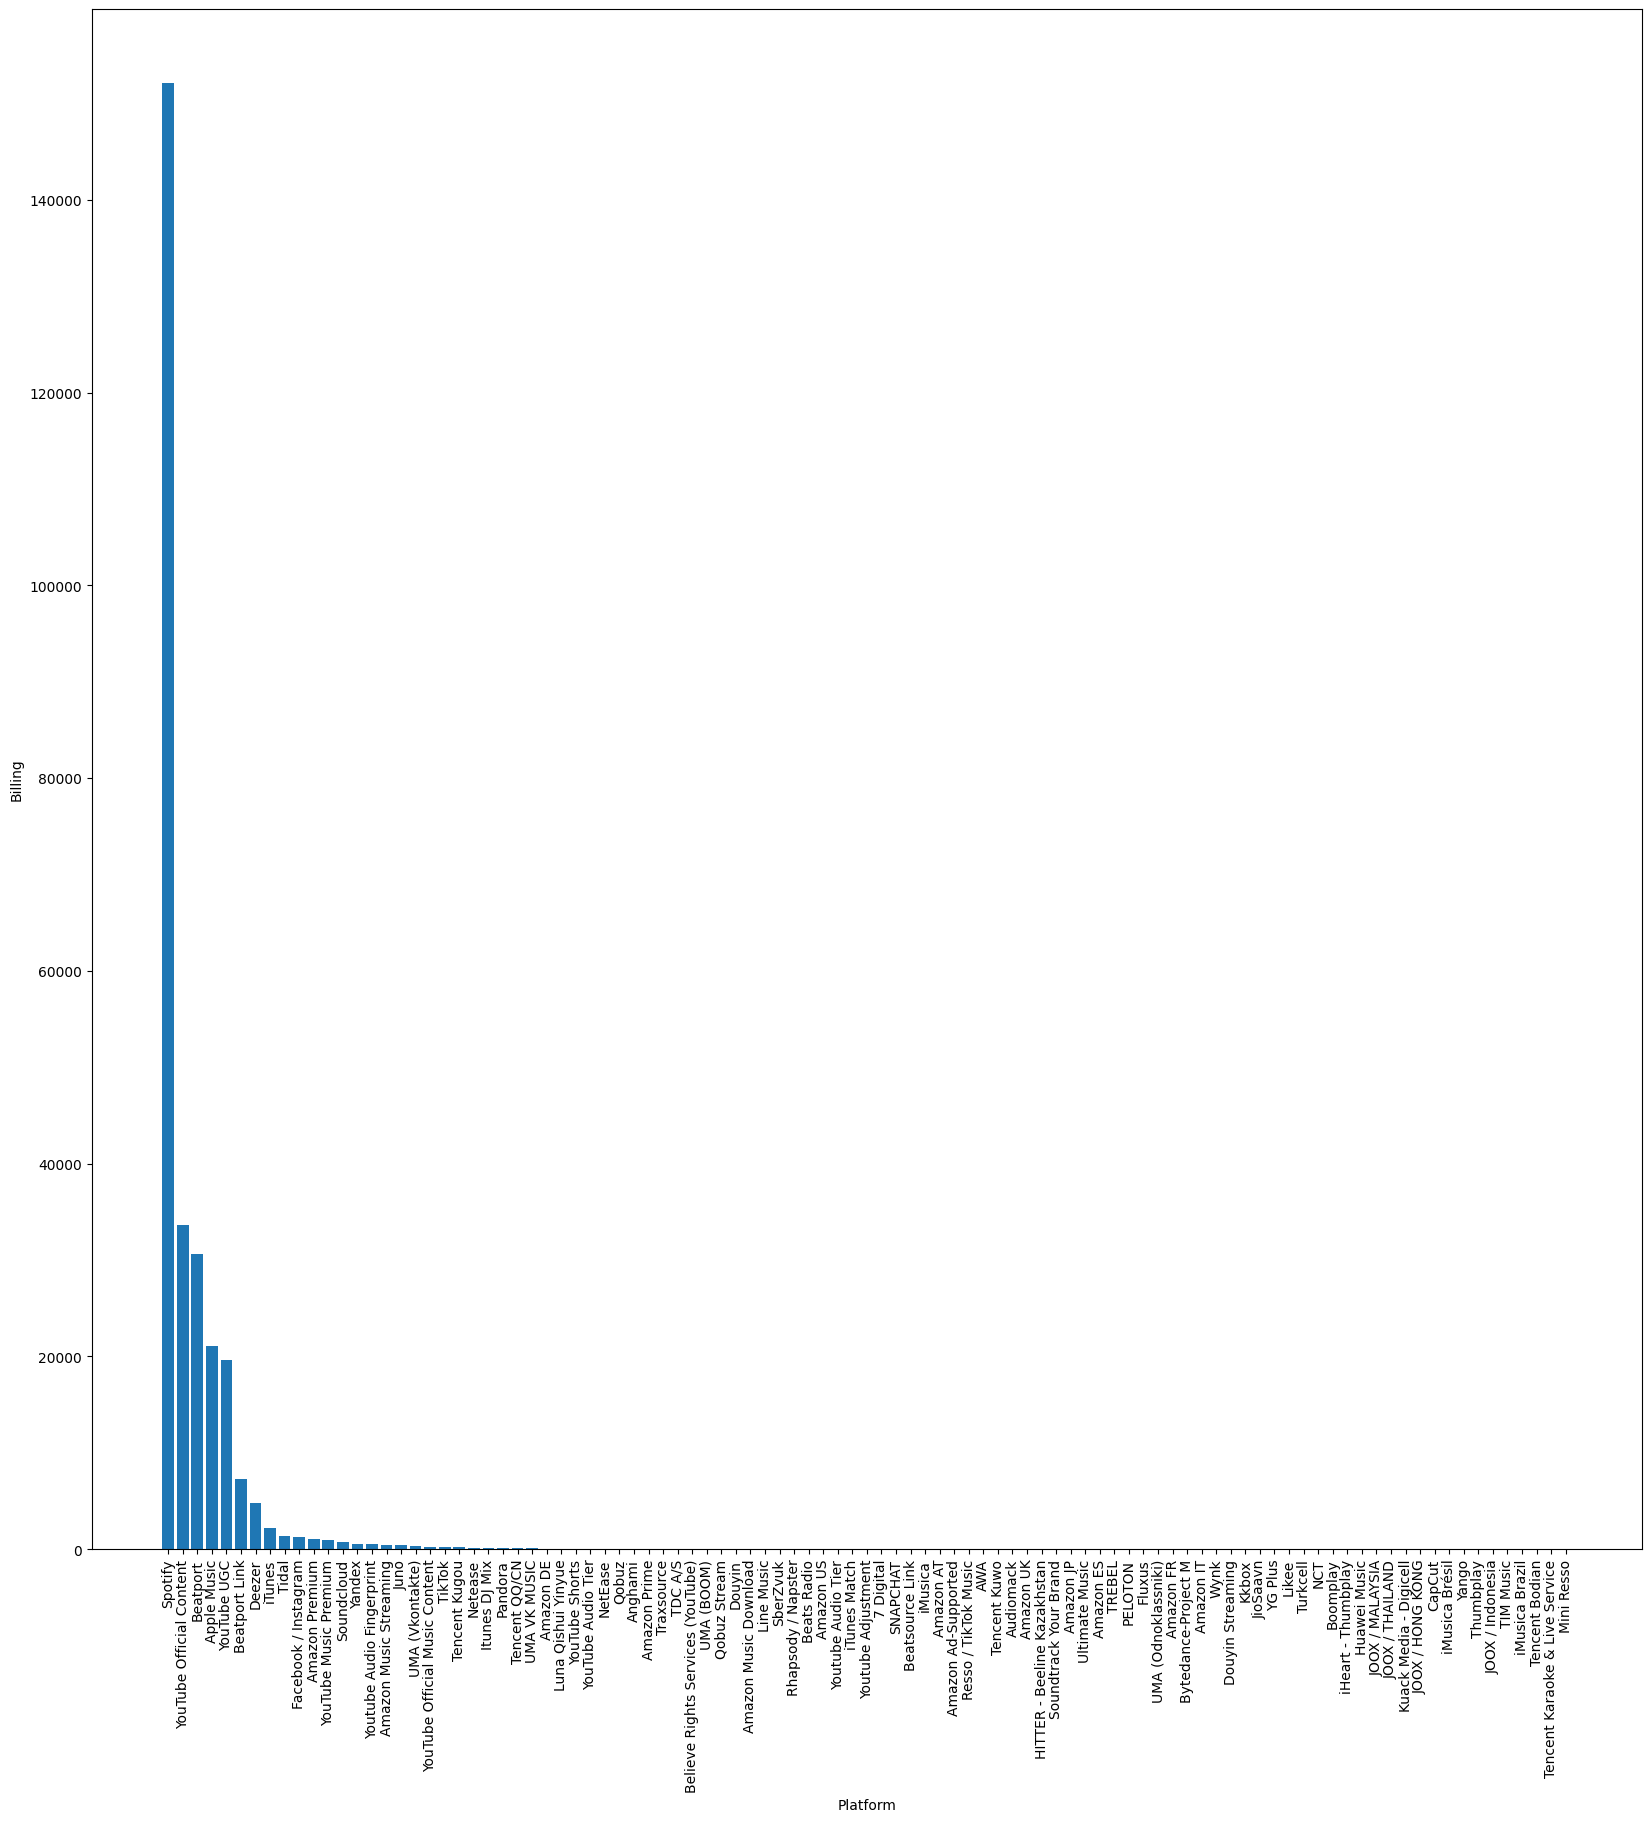

In [59]:
plt.figure(figsize=(20,20))
plt.bar(df_billing_platform['Platform'], df_billing_platform['Billing'])

plt.xlabel('Platform')
plt.ylabel('Billing')
plt.xticks(rotation = 90)
plt.show()

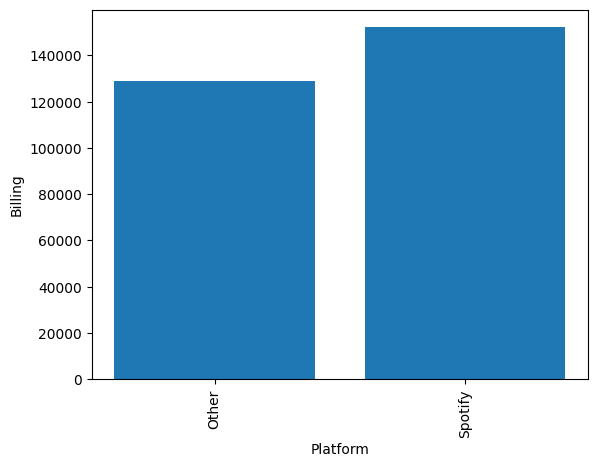

In [90]:
df_billing_platform.loc[df_billing_platform['Platform'] != 'Spotify', 'Platform'] = 'Other'
df_billing_platform = df_billing_platform.groupby("Platform", as_index=False)["Billing"].sum()

plt.bar(df_billing_platform['Platform'], df_billing_platform['Billing'])

plt.xlabel('Platform')
plt.ylabel('Billing')
plt.xticks(rotation = 90)
plt.show()

In [91]:
df_filtered.loc[df_filtered['Platform'] != 'Spotify', 'Platform'] = 'Other'

# Expand artists

In [94]:
# CAUTION: Maybe Mechanic Fee is wrong

In [93]:
df = df_filtered.copy()

# 1) Split artist names and remove empty strings
df["Artist_Name_List"] = (
    df["Artist Name"]
    .str.split(", ")
    .apply(lambda lst: [a for a in lst if a])
)

# 2) Store number of artists per row
df["n_artists"] = df["Artist_Name_List"].str.len()

# 3) Explode so each artist gets its own row
df = df.explode("Artist_Name_List", ignore_index=True)

# 4) Update Artist Name
df["Artist Name"] = df["Artist_Name_List"]

# 5) Recompute values only when multiple artists were present
multi_artist_mask = df["n_artists"] > 1

df.loc[multi_artist_mask, "Quantity"] = (
    df.loc[multi_artist_mask, "Quantity"] // df.loc[multi_artist_mask, "n_artists"]
)

df.loc[multi_artist_mask, "Gross Revenue"] = (
    df.loc[multi_artist_mask, "Quantity"] *
    df.loc[multi_artist_mask, "Unit Price"]
)

df.loc[multi_artist_mask, "Net Revenue"] = (
    df.loc[multi_artist_mask, "Gross Revenue"] *
    df.loc[multi_artist_mask, "Client share rate"]
)

# 6) Clean up helper columns
df = df.drop(columns=["Artist_Name_List", "n_artists"])

# Drop Rows that Unit Price < 0

In [117]:
df = df[df['Unit Price'] > 0].reset_index(drop = True)
df = df[df['Net Revenue'] > 0].reset_index(drop = True)

In [118]:
df.to_parquet(
    "processed_ensemble_2022-07-01_2025-10-01_V.1.0.parquet",
    engine="pyarrow",   # recomendado
    index=False
)

In [119]:
df.head()

,Reporting month,Platform,Country / Region,Artist Name,ISRC,Release type,Quantity,Unit Price,Mechanical Fee,Gross Revenue,Client share rate,Net Revenue
0,2022/09/01,Other,Thailand,Gustav:s,CA-5KR-21-17023,Music Release,3,0.001135,0.0,0.003405,0.765,0.002605
1,2022/09/01,Other,Spain,Gustav:s,CA-5KR-21-17023,Music Release,5,0.001215,0.0,0.006075,0.765,0.004647
2,2022/09/01,Other,Mexico,Gustav:s,CA-5KR-21-17023,Music Release,2,0.000077,0.0,0.000154,0.765,0.000118
3,2022/09/01,Other,Norway,Gustav:s,CA-5KR-21-17023,Music Release,2,0.000571,0.0,0.001142,0.765,0.000874
4,2022/09/01,Other,Ireland,Gustav:s,CA-5KR-21-17023,Music Release,1,0.000307,0.0,0.000307,0.765,0.000235


# Processing for training

In [133]:
df.columns

Index(['Reporting month', 'Platform', 'Country / Region', 'Artist Name',
       'ISRC', 'Release type', 'Quantity', 'Unit Price', 'Mechanical Fee',
       'Gross Revenue', 'Client share rate', 'Net Revenue'],
      dtype='object')

In [137]:
len(df.drop_duplicates())

3803135

In [136]:
len(df.drop(columns = ['Release type']).drop_duplicates())

3803135

In [251]:
df_train = df.copy()
df_train = df_train.drop(columns=['Artist Name', 'Gross Revenue']) # 'Mechanical Fee', 'Client share rate'

In [252]:
df_train = (
    df_train
    .groupby(
        [
        'Reporting month', 
        'Platform', 
        'Country / Region',
        'ISRC',
        'Release type'
        ],
        as_index=False
    )
    .agg(
        Quantity=('Quantity', 'sum'),
        Billing=('Net Revenue', 'sum'),
        Fee=('Mechanical Fee', 'mean'),
        Share_Rate=('Client share rate', 'mean'),
    )
    .sort_values(
        by='Reporting month', 
        ascending=False
    )
)

In [253]:
df_train['Billing'].min()

np.float64(1.335e-09)

In [254]:
df_train['Billing'].max()

np.float64(585.80113588043)

In [255]:
len(df_train)

896243

In [256]:
df_train.columns

Index(['Reporting month', 'Platform', 'Country / Region', 'ISRC',
       'Release type', 'Quantity', 'Billing', 'Fee', 'Share_Rate'],
      dtype='object')

In [257]:
df_train.head()

,Reporting month,Platform,Country / Region,ISRC,Release type,Quantity,Billing,Fee,Share_Rate
896242,2025/10/01,Spotify,Zimbabwe,FR-X45-25-04079,Music Release,1,0.000924,0.0,0.785
870522,2025/10/01,Other,Lebanon,FR-26V-25-65416,Music Video,1,0.000289,0.0,0.785
870520,2025/10/01,Other,Lebanon,FR-26V-25-29469,Music Video,4,0.000193,0.0,0.785
870519,2025/10/01,Other,Lebanon,DG-A0S-24-76437,Music Release,9,0.000326,0.0,0.785
870518,2025/10/01,Other,Lebanon,DG-A0S-24-37834,Music Release,6,0.000364,0.0,0.785


In [258]:
df_train = df_train.rename(columns={
    'Reporting month': 'reporting_month',
    'Platform': 'spotify',
    'Country / Region': 'zone',
    'ISRC': 'ISRC',
    'Release type': 'release_type',
    'Quantity': 'quantity',
    'Billing': 'revenue',
    'Fee': 'mechanical_fee',
    'Share_Rate': 'share_rate'
})

In [259]:
df_train.head()

,reporting_month,spotify,zone,ISRC,release_type,quantity,revenue,mechanical_fee,share_rate
896242,2025/10/01,Spotify,Zimbabwe,FR-X45-25-04079,Music Release,1,0.000924,0.0,0.785
870522,2025/10/01,Other,Lebanon,FR-26V-25-65416,Music Video,1,0.000289,0.0,0.785
870520,2025/10/01,Other,Lebanon,FR-26V-25-29469,Music Video,4,0.000193,0.0,0.785
870519,2025/10/01,Other,Lebanon,DG-A0S-24-76437,Music Release,9,0.000326,0.0,0.785
870518,2025/10/01,Other,Lebanon,DG-A0S-24-37834,Music Release,6,0.000364,0.0,0.785


In [262]:
df_train = df_train.sort_values(
    by=['reporting_month', 'revenue'],
    ascending=[True, True]
).reset_index(drop = True)

In [263]:
df_train.head()

,reporting_month,spotify,zone,ISRC,release_type,quantity,revenue,mechanical_fee,share_rate
0,2022/09/01,Other,Italy,CA-5KR-00-21353,Music Release,1,0.000005,0.0,0.765
1,2022/09/01,Other,Turkey,GX-5MX-22-31727,Music Release,1,0.000005,0.0,0.765
2,2022/09/01,Other,Uruguay,GX-5MX-22-31730,Music Release,1,0.000008,0.0,0.765
3,2022/09/01,Other,Bosnia and herzegovi,CA-5KR-21-13899,Music Release,5,0.000008,0.0,0.765
4,2022/09/01,Other,Jordan,CA-5KR-21-77573,Music Release,1,0.000011,0.0,0.765


In [264]:
df_train.zone.unique()

array(['Italy', 'Turkey', 'Uruguay', 'Bosnia and herzegovi', 'Jordan',
       'Greece', 'Pakistan', 'Ecuador', 'Taiwan', 'Argentina', 'Japan',
       'Egypt', 'Macedonia, the former yugoslav republic of', 'Bermuda',
       'Indonesia', 'El salvador', 'Brazil', 'Liechtenstein', 'Tunisia',
       'Kuwait', 'Kenya', 'India', 'Cyprus', 'Viet nam', 'Malaysia',
       'Saudi arabia', 'Bolivia', 'Ukraine', 'Chile', 'Colombia',
       'Norway', 'Peru', 'Réunion', 'United kingdom', 'Sweden', 'Belgium',
       'Croatia', 'Aruba', 'Serbia and montenegro', 'Canada', 'Singapore',
       'Panama', 'Paraguay', 'Belarus', 'Costa rica', 'Guatemala', 'Iraq',
       'Israel', 'Hong kong', 'Morocco', 'Ireland', 'Lithuania',
       'Denmark', 'Portugal', 'Uganda', 'Algeria', 'Thailand',
       'South africa', 'Romania', 'Philippines', 'Netherlands',
       'Bulgaria', 'United states', 'Dominican republic', 'Hungary',
       'Poland', 'Latvia', 'Georgia', 'Spain', 'United arab emirates',
       'Puerto rico

In [265]:
df_revenue_zone = (
    df_train
    .groupby('zone', as_index=False)['revenue']
    .sum()
    .sort_values(by='revenue', ascending=False)
)

df_revenue_zone['revenue'] = df_revenue_zone['revenue'].round(2)

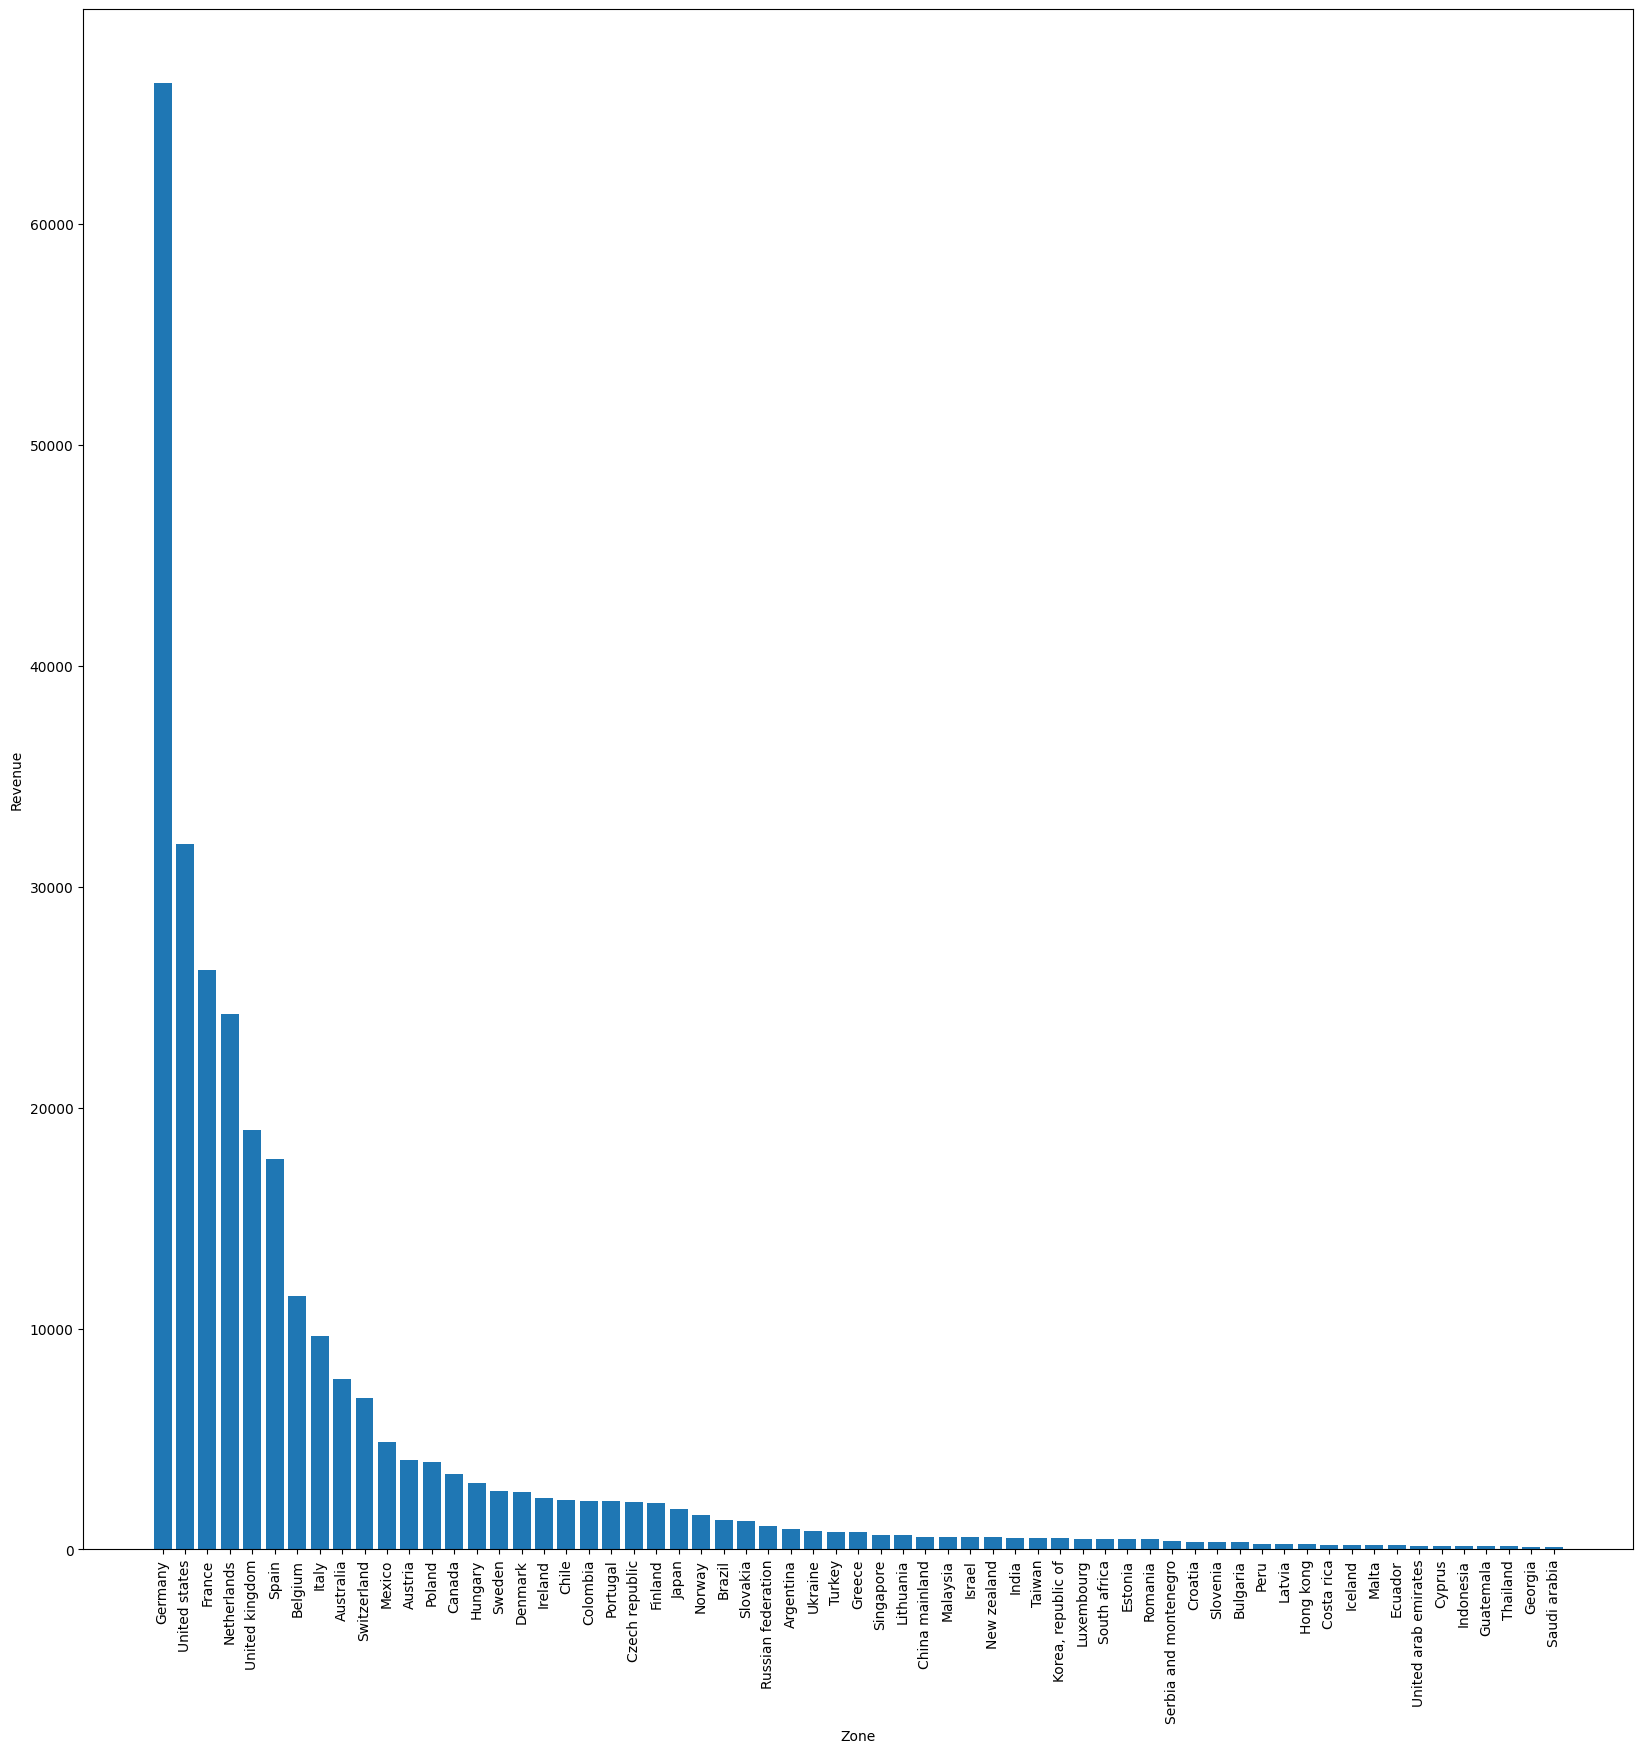

In [267]:
df_revenue_zone_aux = df_revenue_zone[df_revenue_zone['revenue'] >= 100]

plt.figure(figsize=(20,20))
plt.bar(df_revenue_zone_aux['zone'], df_revenue_zone_aux['revenue'])

plt.xlabel('Zone')
plt.ylabel('Revenue')
plt.xticks(rotation = 90)
plt.show()

In [268]:
country_to_continent = {
    # Europa
    'Germany': 'Europe',
    'France': 'Europe',
    'Netherlands': 'Europe',
    'United kingdom': 'Europe',
    'Spain': 'Europe',
    'Belgium': 'Europe',
    'Italy': 'Europe',
    'Switzerland': 'Europe',
    'Austria': 'Europe',
    'Poland': 'Europe',
    'Hungary': 'Europe',
    'Sweden': 'Europe',
    'Denmark': 'Europe',
    'Ireland': 'Europe',
    'Portugal': 'Europe',
    'Czech republic': 'Europe',
    'Finland': 'Europe',
    'Norway': 'Europe',
    'Slovakia': 'Europe',
    'Russian federation': 'Europe',
    'Ukraine': 'Europe',
    'Turkey': 'Europe',
    'Greece': 'Europe',
    'Lithuania': 'Europe',
    'Luxembourg': 'Europe',
    'Estonia': 'Europe',
    'Romania': 'Europe',
    'Serbia and montenegro': 'Europe',
    'Croatia': 'Europe',
    'Slovenia': 'Europe',
    'Bulgaria': 'Europe',
    'Latvia': 'Europe',
    'Iceland': 'Europe',
    'Malta': 'Europe',
    'Cyprus': 'Europe',
    'Georgia': 'Europe',
    'Belarus': 'Europe',
    'Bosnia and herzegovi': 'Europe',
    'Macedonia, the former yugoslav republic of': 'Europe',
    'Albania': 'Europe',
    'Moldova, republic of': 'Europe',
    'Liechtenstein': 'Europe',
    'Monaco': 'Europe',
    'Andorra': 'Europe',
    'San marino': 'Europe',
    'Åland islands': 'Europe',
    'Gibraltar': 'Europe',
    'Faroe islands': 'Europe',
    'Svalbard and jan mayen': 'Europe',
    
    # América del Norte
    'United states': 'North America',
    'Canada': 'North America',
    
    # LATAM (América Latina y el Caribe)
    'Mexico': 'LATAM',
    'Chile': 'LATAM',
    'Colombia': 'LATAM',
    'Brazil': 'LATAM',
    'Argentina': 'LATAM',
    'Peru': 'LATAM',
    'Costa rica': 'LATAM',
    'Ecuador': 'LATAM',
    'Guatemala': 'LATAM',
    'Uruguay': 'LATAM',
    'Bolivia': 'LATAM',
    'El salvador': 'LATAM',
    'Paraguay': 'LATAM',
    'Panama': 'LATAM',
    'Honduras': 'LATAM',
    'Dominican republic': 'LATAM',
    'Puerto rico': 'LATAM',
    'Venezuela': 'LATAM',
    'Nicaragua': 'LATAM',
    'Réunion': 'LATAM',
    'Guadeloupe': 'LATAM',
    'Belize': 'LATAM',
    'Aruba': 'LATAM',
    'Jamaica': 'LATAM',
    'Martinique': 'LATAM',
    'Guyana': 'LATAM',
    'French guiana': 'LATAM',
    'Suriname': 'LATAM',
    'Bahamas': 'LATAM',
    'Barbados': 'LATAM',
    'Haiti': 'LATAM',
    'Saint pierre and miquelon': 'LATAM',
    'Saint lucia': 'LATAM',
    'Anguilla': 'LATAM',
    'Virgin islands, u.s.': 'LATAM',
    'Saint vincent and the grenadines': 'LATAM',
    'Antigua and barbuda': 'LATAM',
    'Turks and caicos islands': 'LATAM',
    'Saint kitts and nevis': 'LATAM',
    'Grenada': 'LATAM',
    'Dominica': 'LATAM',
    'Cuba': 'LATAM',
    'Falkland islands (malvinas)': 'LATAM',
    'Virgin islands, british': 'LATAM',
    'Cayman islands': 'LATAM',
    'Trinidad and tobago': 'LATAM',
    
    # Asia
    'Japan': 'Asia',
    'Singapore': 'Asia',
    'China mainland': 'Asia',
    'Malaysia': 'Asia',
    'Israel': 'Asia',
    'India': 'Asia',
    'Taiwan': 'Asia',
    'Korea, republic of': 'Asia',
    'Indonesia': 'Asia',
    'Thailand': 'Asia',
    'Saudi arabia': 'Asia',
    'Philippines': 'Asia',
    'Kazakhstan': 'Asia',
    'Jordan': 'Asia',
    'Lebanon': 'Asia',
    'Kuwait': 'Asia',
    'Azerbaijan': 'Asia',
    'Qatar': 'Asia',
    'Mongolia': 'Asia',
    'Pakistan': 'Asia',
    'Armenia': 'Asia',
    'Bahrain': 'Asia',
    'Brunei darussalam': 'Asia',
    'Bangladesh': 'Asia',
    'Oman': 'Asia',
    'Cambodia': 'Asia',
    'Uzbekistan': 'Asia',
    'Iraq': 'Asia',
    'Sri lanka': 'Asia',
    'Kyrgyzstan': 'Asia',
    'Myanmar': 'Asia',
    'Macao': 'Asia',
    'Palestinian territory, occupied': 'Asia',
    'Nepal': 'Asia',
    'Lao people s democratic republic': 'Asia',
    'Syrian arab republic': 'Asia',
    'Turkmenistan': 'Asia',
    'Iran, islamic republ': 'Asia',
    'Yemen': 'Asia',
    'Afghanistan': 'Asia',
    'Bhutan': 'Asia',
    'Timor-leste': 'Asia',
    'Viet nam': 'Asia',
    'Hong kong': 'Asia',
    'United arab emirates': 'Asia',
    'Maldives': 'Asia',
    
    # Oceanía
    'Australia': 'Oceania',
    'New zealand': 'Oceania',
    'Papua new guinea': 'Oceania',
    'French polynesia': 'Oceania',
    'Guam': 'Oceania',
    'New caledonia': 'Oceania',
    'Fiji': 'Oceania',
    'Vanuatu': 'Oceania',
    'Palau': 'Oceania',
    'Northern mariana islands': 'Oceania',
    'American samoa': 'Oceania',
    'Cook islands': 'Oceania',
    'Micronesia, federated states of': 'Oceania',
    'Samoa': 'Oceania',
    'Solomon islands': 'Oceania',
    'Wallis and futuna': 'Oceania',
    'Tonga': 'Oceania',
    'Kiribati': 'Oceania',
    'Marshall islands': 'Oceania',
    'Tuvalu': 'Oceania',
    'Norfolk island': 'Oceania',
    'Niue': 'Oceania',
    'Cocos (keeling) islands': 'Oceania',
    'Nauru': 'Oceania',
    
    # África
    'South africa': 'Africa',
    'Egypt': 'Africa',
    'Morocco': 'Africa',
    'Nigeria': 'Africa',
    'Algeria': 'Africa',
    'Tunisia': 'Africa',
    'Mauritius': 'Africa',
    'Namibia': 'Africa',
    'Kenya': 'Africa',
    'Côte d ivoire': 'Africa',
    'Ghana': 'Africa',
    'Sudan (the)': 'Africa',
    'Djibouti': 'Africa',
    'Botswana': 'Africa',
    'Zimbabwe': 'Africa',
    'Tanzania, united republic of': 'Africa',
    'Mozambique': 'Africa',
    'Eswatini': 'Africa',
    'Angola': 'Africa',
    'Seychelles': 'Africa',
    'Madagascar': 'Africa',
    'Senegal': 'Africa',
    'Libyan arab jamahiriya': 'Africa',
    'Uganda': 'Africa',
    'Benin': 'Africa',
    'Zambia': 'Africa',
    'Cameroon': 'Africa',
    'Somalia': 'Africa',
    'Ethiopia': 'Africa',
    'Mauritania': 'Africa',
    'Liberia': 'Africa',
    'Rwanda': 'Africa',
    'Mali': 'Africa',
    'Burkina faso': 'Africa',
    'Malawi': 'Africa',
    'Lesotho': 'Africa',
    'Congo, the democratic republic of the': 'Africa',
    'Gabon': 'Africa',
    'Sierra leone': 'Africa',
    'Cape verde': 'Africa',
    'Guinea': 'Africa',
    'Chad': 'Africa',
    'Togo': 'Africa',
    'Equatorial guinea': 'Africa',
    'Guinea-bissau': 'Africa',
    'Niger': 'Africa',
    'Congo': 'Africa',
    'Gambia': 'Africa',
    'Saint helena': 'Africa',
    
    # Territorios especiales
    'French southern territories': 'Europe', # Antartica
    'Bermuda': 'North America',
    'Greenland': 'North America',
    'Mayotte': 'Africa',
    'United states minor outlying islands': 'Oceania',
    'Tajikistan': 'Asia',
    
    # Casos especiales
    'Worldwide': 'Other'
}

In [269]:
df_revenue_zone.loc[:,"zone"] = df_revenue_zone["zone"].map(country_to_continent).fillna("Other")

df_revenue_zone = (
    df_revenue_zone
        .groupby('zone', as_index=False)['revenue']
        .sum()
        .sort_values(by='revenue', ascending=False)
)

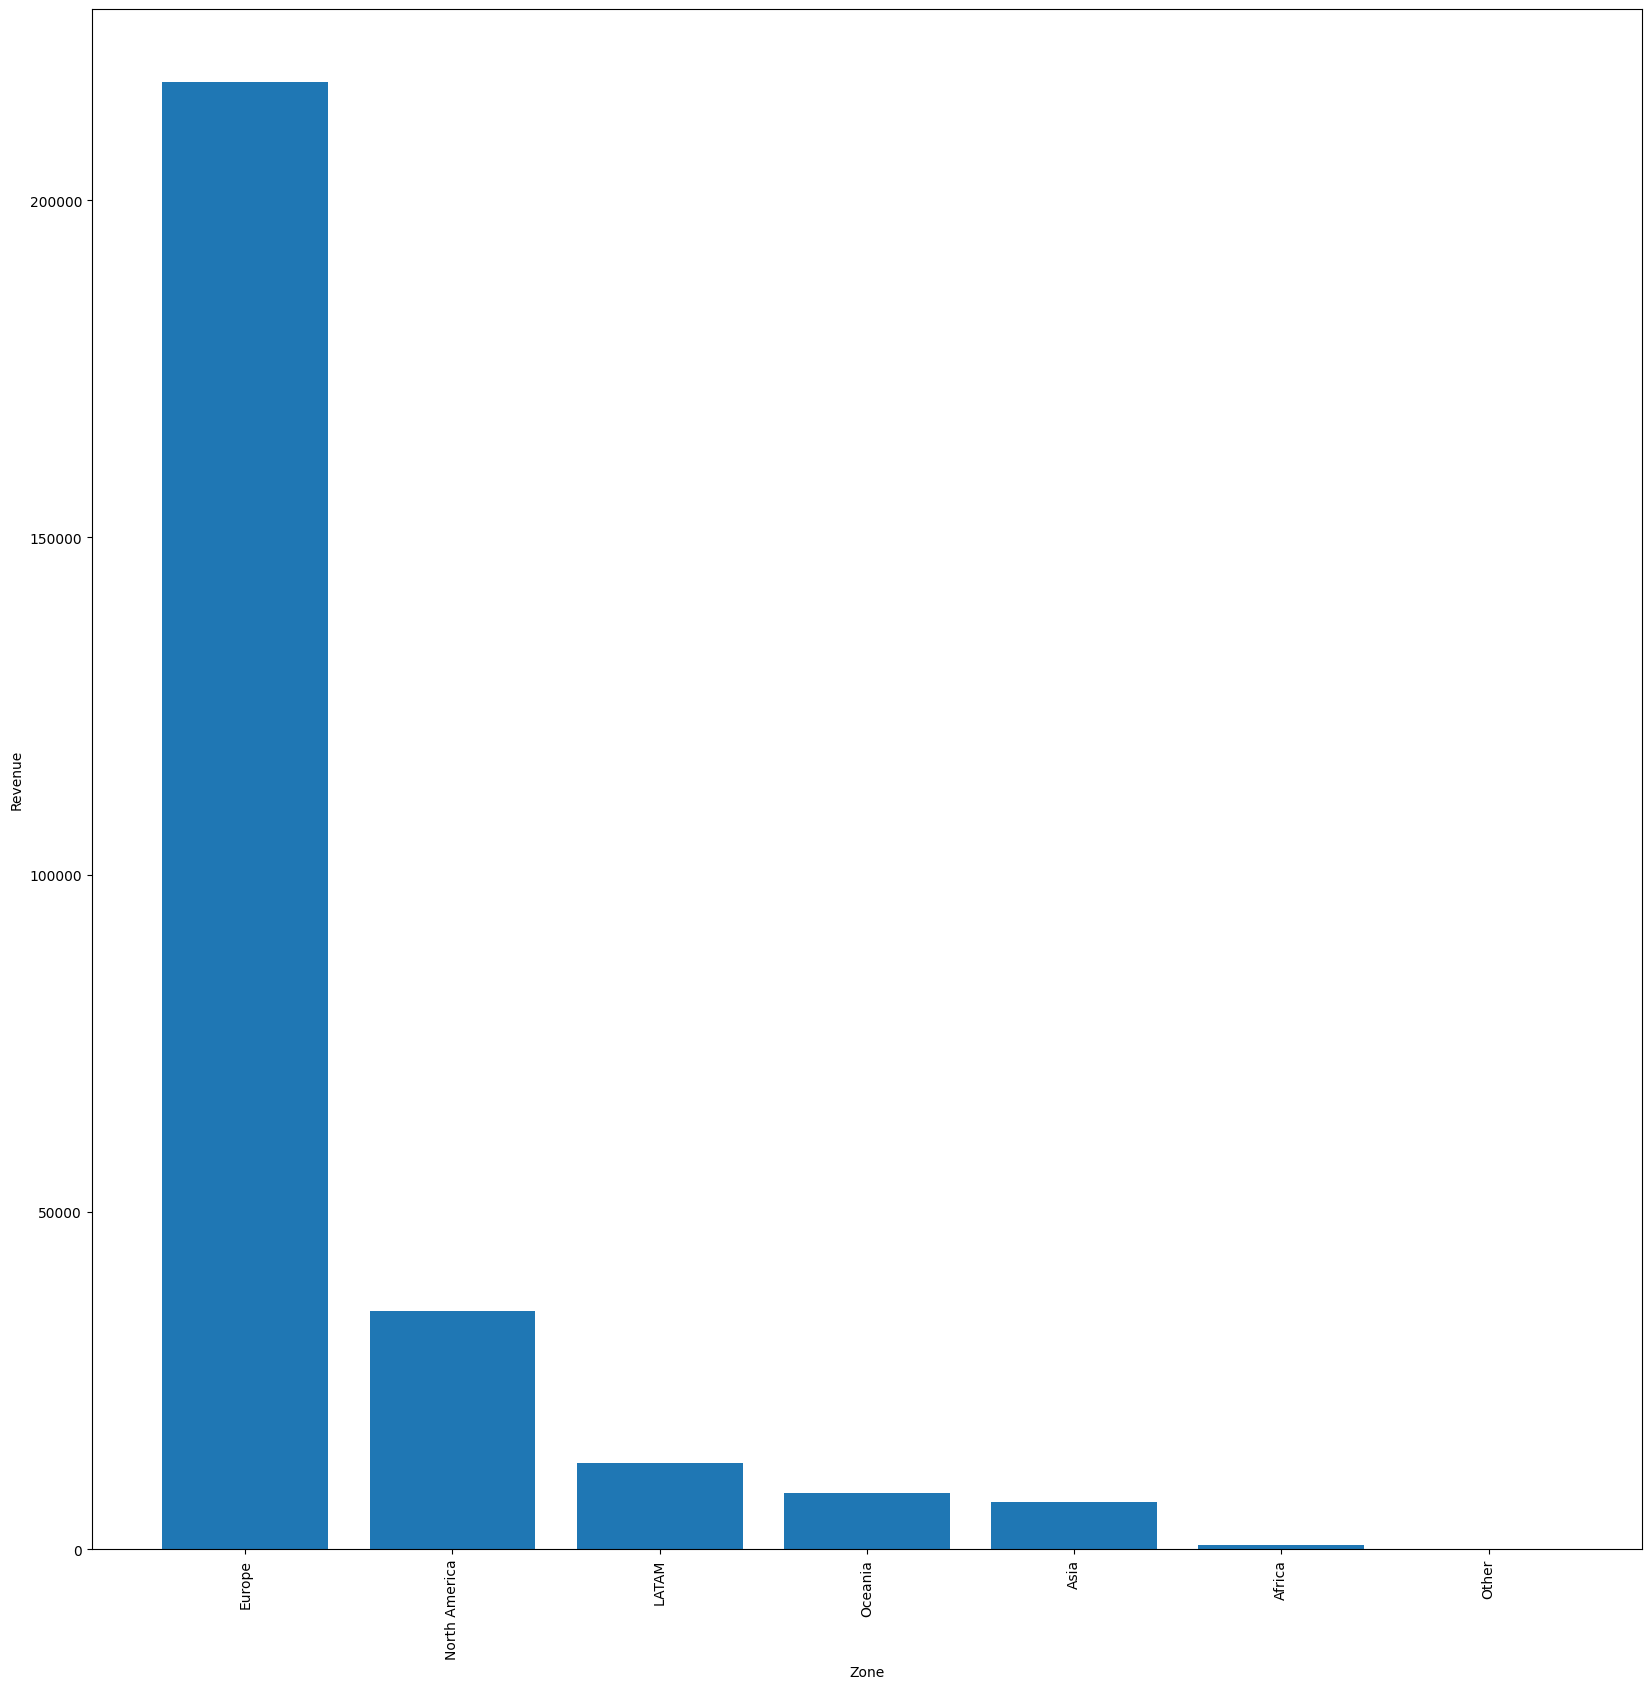

In [270]:
plt.figure(figsize=(20,20))
plt.bar(df_revenue_zone['zone'], df_revenue_zone['revenue'])

plt.xlabel('Zone')
plt.ylabel('Revenue')
plt.xticks(rotation = 90)
plt.show()

In [271]:
df_train['continent'] = df_train["zone"].map(country_to_continent).fillna("Other")

In [272]:
df_train.columns

Index(['reporting_month', 'spotify', 'zone', 'ISRC', 'release_type',
       'quantity', 'revenue', 'mechanical_fee', 'share_rate', 'continent'],
      dtype='object')

In [273]:
df_train = df_train[["reporting_month", "ISRC", "spotify", "release_type", "continent", "zone", "quantity", "mechanical_fee", "share_rate", "revenue"]]
df_train.head()

,reporting_month,ISRC,spotify,release_type,continent,zone,quantity,mechanical_fee,share_rate,revenue
0,2022/09/01,CA-5KR-00-21353,Other,Music Release,Europe,Italy,1,0.0,0.765,0.000005
1,2022/09/01,GX-5MX-22-31727,Other,Music Release,Europe,Turkey,1,0.0,0.765,0.000005
2,2022/09/01,GX-5MX-22-31730,Other,Music Release,LATAM,Uruguay,1,0.0,0.765,0.000008
3,2022/09/01,CA-5KR-21-13899,Other,Music Release,Europe,Bosnia and herzegovi,5,0.0,0.765,0.000008
4,2022/09/01,CA-5KR-21-77573,Other,Music Release,Asia,Jordan,1,0.0,0.765,0.000011


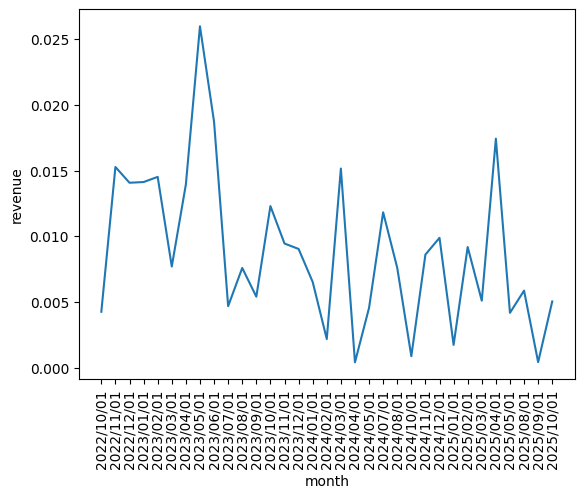

In [274]:
df_aux = df_train[
    (df_train['ISRC'] == "CA-5KR-00-21353") & \
    (df_train['zone'] == "Italy") & \
    (df_train['spotify'] == "Spotify") & \
    (df_train['release_type'] == "Music Release")
    ]

plt.plot(df_aux['reporting_month'], df_aux['revenue'])
plt.xticks(rotation = 90)
plt.xlabel("month")
plt.ylabel("revenue")
plt.show()

In [275]:
df_train.to_parquet(
    "df_train_ensemble_2022-07-01_2025-10-01_V.1.0.parquet",
    engine="pyarrow",   # recomendado
    index=False
)